## Predicting Airbnb prices in Montréal

In this notebook, we will be answering the following Questions about Airbnb market in Montréal, QC, Canada.

* What is the share of private rooms vs entire houses in Montreal?

* What is the average price listing per room type per neighbourhood?

* What is the effect of the season on price listing or in other words how does the prices change over time?

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pathlib import Path
import requests 
from IPython.display import display
# %matplotlib inline

### download airbnb dataset from source.
Download the datasets need from source if they are not already there. 

In [152]:
# download data to project folder listings.csv.gz
# This will create a subfolder where this notebook is installed and download the file.

data_src = 'listings.csv.gz'
url= 'http://data.insideairbnb.com/canada/qc/montreal/2020-03-17/data/listings.csv.gz'

def download_url(url, save_path, chunk_size=256):
    """
    Check if file already exists, if not use url to download it.
    Args:
        url(str): URL of the zipped file.
        save_path(str): Path where the file should be saved
        chunk_size(int): Chunk size to iterate over from the streamed request.
    """
    # check if file exists at path or not
    if not Path(save_path).exists():
        r = requests.get(url, stream=True)
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)

# Download from url if file doesn't exist.
download_url(url, data_src)

    
# Display all columns to have an understanding of the feature vectors provided. 
pd.options.display.max_columns = None

### Cleaning up the dataframe. 
Here we will:
* Drop all the columns that are empty
* Remove columns that are deemed unnecessary to answer the above mentioned questions.
* Make sure that the datatypes are in the right type, else update these to make use of the data.

These 2 points could be done as we are answering the questions: 

* Check categorical data and they need to be imputed/dummies be created.
* Deal with missing values in columns in the appropriate way as we are answering the questions.


In [153]:
# Read the compressed csv file to a pandas dataframe. This is in a separate cell as to run it once.
df = pd.read_csv(data_src, compression='gzip', error_bad_lines=False)

# drop empty columns inplace in the same cell and get the names of the dropped columns
num_features_before = set(df.columns)
df.dropna(how='all',axis=1,inplace=True)
num_features_after = set(df.columns)

print(f'Dropped columns are: {(num_features_before - num_features_after)}')

/Users/faisalbarazi/projects/airbnb_mtl_prices/airbnb_mtl_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dropped columns are: {'neighbourhood_group_cleansed', 'thumbnail_url', 'xl_picture_url', 'medium_url', 'license'}


In [171]:
# Explore the dataset a bit
df.head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-08-19,within an hour,100%,0%,f,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,Le Plateau-Mont-Royal,H2J 3E9,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,NaN,39.0,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,t,0,0,0,76,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,t,f,flexible,f,f,1,0,1,0,2.36
1,2008-08-19,within an hour,100%,100%,f,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Le Sud-Ouest,H3J 2K3,45.48496,-73.58001,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,30.0,$245.00,$650.00,$134.00,$25.00,1,$10.00,1,365,1,1,365,365,1.0,365.0,t,0,0,15,286,2020-03-18,143,29,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,f,t,f,moderate,f,f,6,3,3,0,1.09
2,2009-11-25,within a few hours,90%,74%,t,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,Le Plateau-Mont-Royal,H2H 2P9,45.54135,-73.57814,f,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,175.0,$950.00,"$3,000.00",$200.00,$0.00,2,$20.00,3,1125,3,3,1125,1125,3.0,1125.0,t,24,52,77,342,2020-03-18,175,30,2011-06-06,2020-03-01,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.64
3,2010-05-14,within an hour,100%,99%,t,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Ville-Marie,H2L 3V1,45.51939,-73.56482,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,80.0,NaN,NaN,$0.00,$75.00,2,$15.00,2,60,2,2,60,60,2.0,60.0,t,22,35,48,288,2020-03-18,324,48,2010-06-20,2020-03-08,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,moderate,f,f,2,2,0,0,2.73
4,2010-05-14,within an hour,100%,99%,t,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Ville-Marie,H2L 3V1,45.51929,-73.56493,t,House,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,145.0,NaN,NaN,$0.00,$120.00,2,$20.00,3,21,3,3,21,21,3.0,21.0,t,19,36,60,297,2020-03-18,66,21,2012-02-23,2020-02-17,92.0,10.0,9.0,9.0,9.0,10.0,9.0,f,t,f,moderate,f,f,2,2,0,0,0.67


In [159]:
# Further clean up the dataframe by droping un-useful data. 
columns_to_drop = [
    'state', 'city', 'neighbourhood', 'street', 'host_picture_url','host_thumbnail_url',
    'host_about', 'host_location','host_url' ,'host_id', 'picture_url','house_rules',
    'access', 'interaction', 'notes', 'neighborhood_overview', 'description', 'space',
    'name','scrape_id', 'listing_url','id','transit','experiences_offered','summary','host_name',
    'host_neighbourhood', 'smart_location','country_code','country','market','amenities',
    'jurisdiction_names','last_scraped','calendar_updated'
]
df.drop(columns=columns_to_drop,axis=1, inplace=True)


In [160]:
# Prices are not in the correct datatype, so we are droping the dollar sign and number separator.
def prices_cleaner(value):
    if value:
        value = str(value).replace('$','')
        value = value.replace(',','')
        value = float(value)
        return value
df['price'] = df['price'].apply(prices_cleaner)

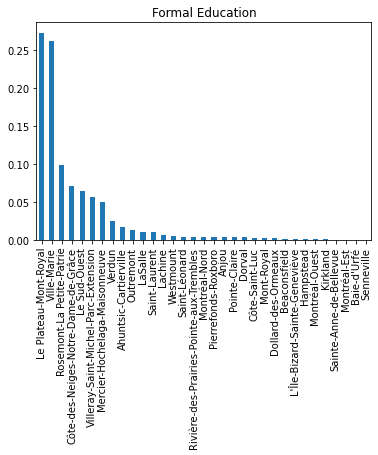